# BATTLE OF NEIGHBORHOODS - ADELAIDE INDIAN RESTAURANTS
### Applied Data Science Capstone Project Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Acquisition](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**_Adelaide_**, the capital of South Australia, is a vibrant city with plenty of attractions and a rich cultural heritage. This city boasts a lot of multicultural restaurants and is particularly known for the world famous wine regions only minutes away from the main city. It is also the largest city in South Australia with a history of international immigration. They come from many parts of the world. 

The census data of 2016 revealed that the Indian population in Australia has grown to 455,389, up from 295,362 recorded in Census 2011. Of Australia's 24.4 million people, today Indians comprise of 1.9% of the total population.With its diverse culture, comes the diverse cuisine. 

Here I am considering a business proposal to invest in or open an **_Indian restaurant in Adelaide_**. Hence, as part of this project we will be exploring the best locations for opening an Indian restaurants in Adelaide, Australia. Since there are lots of restaurants in Adelaide I will try to look for locations with not many restaurants. We are also particularly interested in areas which are popular with people to ensure good influx of customers. 
I will make use of the data science knowledge attained during this course to come up with the possible LGAs based on this criteria.

In [1]:
#Importing all the libraries
import pandas as pd # library for data analsysis
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install the Geocoder
!pip -q install geocoder
import geocoder

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from folium import plugins

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\anike\Anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.0                |           py37_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  conda                                       4.7.12-py37_1 --> 4.8.0-py37_0




conda-4.8.0          | 3.0 MB    |            |   0% 
conda-4.8.0          | 3.0 MB    |            |   1% 
conda-4.8.0          | 3.0 MB    | 6          |   6% 
conda-4.8.0          | 3.0 MB    | #          |  11% 
conda-4.8.0          | 3.0 MB    | #5         |  15% 
conda-4.8.0          | 3.0 MB    | #9         |  19% 
conda-4.8.0          | 3.0 MB    | ##3      

## Data Acquisition <a name="data"></a>

For this project we will be using following data sources:

1. Adelaide Suburbs and Local Government Areas with the post codes.


Data will be retrieved from the Wikipedia page https://en.wikipedia.org/wiki/List_of_Adelaide_suburbs.
The data source includes the suburbs of Adelaide, the capital city of South Australia, with their postcodes and local government areas (LGAs). 

2. Adelaide location data retrieved using Arcgis Geocoder.


Data coordinates of all the suburbs retrieved from the above data source will be retrieved using Arcgis geocoder. 

3. Adelaide Venue Details using FourSquare API www.foursquare.com.


The FourSquare API will be used to explore suburbs in City of Adelaide. The Foursquare search function will be used to get Indian restaurants in each suburb and the suburbs will also be grouped into clusters based on the popular nearby venues. The following information is retrieved:

* Venue ID
* Venue Name
* Venue Coordinates i.e. Latitude and Longitude
* Venue Category

## Methodology <a name="methodology"></a>

### Data Cleanup and Re-grouping

We first parse the Wikipedia page using the BeautifulSoup python library and transform the data from the table into a pandas dataframe. 
We can see in the dataframe that there is more than one Suburb for some postal codes. Such rows are combined into one row with the suburbs separated with a comma.

In [2]:
data_url=requests.get('https://en.wikipedia.org/wiki/List_of_Adelaide_suburbs').text

In [3]:
#Using BeautifulSoup function to create an object and parse the html. Prettify helps view the nested tags
soup = BeautifulSoup(data_url,'lxml')
soup.prettify()
adelaidelist=soup.find('table',{'class' :'wikitable sortable'})

#The 3 columns PostCode, Suburb, LGA (Local Government Areas) represented by below 3 empty lists
P= []
S= []
L= []

#Using the find_all to look for <tr> tag
for row in adelaidelist.find_all('tr'):
    cells=row.find_all('td')     #Using the find_all to look for <td> tag in each row
    if len(cells) == 7:
        S.append(cells[0].find(text=True))
        P.append(cells[1].find(text=True))
        L.append(cells[2].find(text=True))

#Creating a dataframe with the lists P, S and L
df_adelaide=pd.DataFrame()
df_adelaide['PostalCode']=P
df_adelaide['Suburb']=S
df_adelaide['LGA']=L
df_adelaide.head()

,PostalCode,Suburb,LGA
0,5000,Adelaide,City of Adelaide
1,5006,North Adelaide,City of Adelaide
2,5072,Auldana,City of Burnside
3,5066,Beaumont,City of Burnside
4,5067,Beulah Park,City of Burnside


In [4]:
# Group Neighborhoods of each PostalCode
sorted_adelaide= df_adelaide.groupby(['PostalCode','LGA'],as_index=False).agg({'Suburb' : ','.join})
sorted_adelaide.head()

,PostalCode,LGA,Suburb
0,5000,City of Adelaide,Adelaide
1,5006,City of Adelaide,North Adelaide
2,5007,City of Charles Sturt,"Bowden,Brompton,Hindmarsh,Welland,West Hindmarsh"
3,5008,City of Charles Sturt,"Croydon,Devon Park,Renown Park,Ridleyton,West ..."
4,5008,City of Port Adelaide Enfield,"Croydon Park,Devon Park,Dudley Park"


### Retrieve coordinates

We will be using arcgis geocoder to retrieve the coordinates (latitude and longitude) of each LGA.These coordinates will be used in retrieval of Foursquare API location data. The coordinates are then merged with the dataframe with the postal codes and suburbs.

In [5]:
# Defining a function to get the latitude and longitude values -- getlatlong()
def getlatlong(arcgis_geocoder):
    
    #Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    #While loop to get all the location coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Adelaide, Australia'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
        
    return lat_lng_coords
# Geocoder ends here

In [6]:
postal_codes = sorted_adelaide['PostalCode']    
coordinates = [getlatlong(postal_code) for postal_code in postal_codes.tolist()]

In [7]:
city_adelaide = sorted_adelaide
# The obtained coordinates (latitude and longitude) are merged with the adelaide dataframe
df_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
city_adelaide['Latitude'] = df_coordinates['Latitude']
city_adelaide['Longitude'] = df_coordinates['Longitude']
city_adelaide.head()

,PostalCode,LGA,Suburb,Latitude,Longitude
0,5000,City of Adelaide,Adelaide,-34.925650,138.599907
1,5006,City of Adelaide,North Adelaide,-34.909165,138.594803
2,5007,City of Charles Sturt,"Bowden,Brompton,Hindmarsh,Welland,West Hindmarsh",-34.901890,138.570164
3,5008,City of Charles Sturt,"Croydon,Devon Park,Renown Park,Ridleyton,West ...",-34.888220,138.567377
4,5008,City of Port Adelaide Enfield,"Croydon Park,Devon Park,Dudley Park",-34.888220,138.567377


Now we determine the geographical location of Adelaide

In [8]:
address = 'Adelaide, Australia'
geolocator = Nominatim(user_agent="adelaide_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Adelaide are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Adelaide are -34.9281805, 138.5999312.


## Analysis <a name="analysis"></a>

### Foursquare API
We will now be using Foursquare API to get the information on the various venues in Adelaide 

In [9]:
#Defining FourSquare credentials for utilizing the Foursquare APIs
# The code was removed for sharing.

### 1. Exploring Neighbourhoods in Adelaide

Using the below Four Square API query url, I have explored venues in all suburbs in Adelaide. 
https://api.foursquare.com/v2/venues/explore?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&radius=RADIUS&limit=LIMIT

The function getNearbyVenues extracts the following information for the dataframe it generates - Venue ID, Venue Name, Venue Coordinates (Latitude and Longitude), Category Name and Category Id.

The function getVenues performs a category based venue search to simulate user venue searches based on certain places of interest. This search extracts the following information - Venue ID, Venue Name, Venue Coordinates (Latitude and Longitude) and Category Name.

In [10]:
#Creating a function to get all the relevant restaurant details for all suburbs
def getVenues(lga, names, latitudes, longitudes, radius=500):
    
    search_list=[]
    for lga, name, lat, lng in zip(lga, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        # return only relevant information for each nearby venue
        search_list.append([(
            lga,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    search_venues = pd.DataFrame([item for search_list in search_list for item in search_list])
    search_venues.columns = ['LGA',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',           
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(search_venues)

In [11]:
#Creating a function to get all the nearby venues for all suburbs
def getNearbyVenues(lga,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for lga, name, lat, lng in zip(lga,names, latitudes, longitudes):
           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            lga,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['LGA',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Category ID']
    
    return(nearby_venues)

In [12]:
# Getting the top 100 restaurants that are within a radius of 500 meters.
LIMIT = 100 # limit of number of results returned by Foursquare API
radius = 500 # define radius
search_query = 'Indian Restaurant'

In [13]:
#Getting Indian restaurants for suburbs in all LGAs of Adelaide in a dataframe
adelaideIndianRestaurants = getVenues(lga=city_adelaide['LGA'],
                                   names=city_adelaide['Suburb'],
                                   latitudes=city_adelaide['Latitude'],
                                   longitudes=city_adelaide['Longitude']
                                  )

In [14]:
adelaideIndianRestaurants.head()

,LGA,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,City of Adelaide,Adelaide,-34.925650,138.599907,North Indian Cruisine,514554c1e4b0925710e32dbb,-34.923061,138.597896,Indian Restaurant
1,City of Adelaide,Adelaide,-34.925650,138.599907,Jasmin Indian Restaurant,4b58544df964a5200a5328e3,-34.923819,138.604814,Indian Restaurant
2,City of Adelaide,Adelaide,-34.925650,138.599907,Bollywood Indian Restaurant,4c64d5c33f69c9b68cd689d9,-34.923620,138.597370,Indian Restaurant
3,City of Adelaide,North Adelaide,-34.909165,138.594803,Arya Indian Cuisine,4c01cca03ab80f473fc890ff,-34.906605,138.596047,Indian Restaurant
4,City of Adelaide,North Adelaide,-34.909165,138.594803,Drunken Monkey,5abf60f289b06a46fba34840,-34.908020,138.596130,Indian Restaurant


In [15]:
adelaideIndianRestaurants.shape

(51, 9)

There are a total of 51 Indian restaurants in Adelaide

We will now save the results in a csv file to avoid losing the data since the number of API calls are limited in our Foursquare account.

In [16]:
adelaideIndianRestaurants.to_csv('adelaideIndianRestaurants.csv', index=False)

In [17]:
adelaide_indianres=pd.read_csv('adelaideIndianRestaurants.csv')
adelaide_indianres.head()

,LGA,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,City of Adelaide,Adelaide,-34.925650,138.599907,North Indian Cruisine,514554c1e4b0925710e32dbb,-34.923061,138.597896,Indian Restaurant
1,City of Adelaide,Adelaide,-34.925650,138.599907,Jasmin Indian Restaurant,4b58544df964a5200a5328e3,-34.923819,138.604814,Indian Restaurant
2,City of Adelaide,Adelaide,-34.925650,138.599907,Bollywood Indian Restaurant,4c64d5c33f69c9b68cd689d9,-34.923620,138.597370,Indian Restaurant
3,City of Adelaide,North Adelaide,-34.909165,138.594803,Arya Indian Cuisine,4c01cca03ab80f473fc890ff,-34.906605,138.596047,Indian Restaurant
4,City of Adelaide,North Adelaide,-34.909165,138.594803,Drunken Monkey,5abf60f289b06a46fba34840,-34.908020,138.596130,Indian Restaurant


In [18]:
adelaide_indianres.shape

(51, 9)

## 2. Analyzing the LGAs and suburbs in Adelaide

Now we determine which LGA in Adelaide has the highest number of suburbs. We can see from the below plot that **City of Onkaparinga and City of Port Adelaide Enfield** are the top 2 LGAs. 

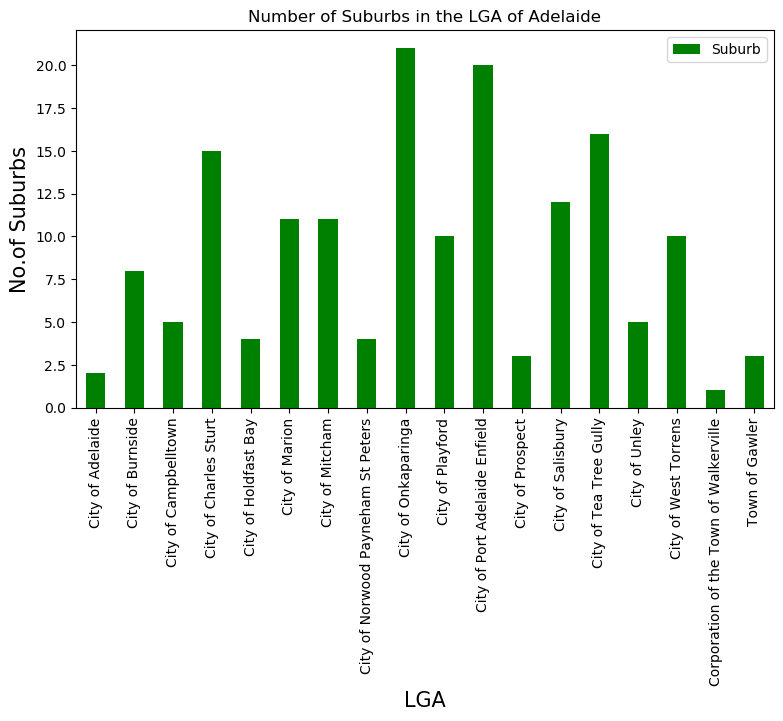

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Suburbs in the LGA of Adelaide')
plt.xlabel('LGA', fontsize = 15)
plt.ylabel('No.of Suburbs', fontsize=15)
city_adelaide.groupby('LGA')['Suburb'].count().plot(kind='bar', color='g')
plt.legend()
plt.show()

Now we determine the number of **Indian restaurants** in each suburb of adelaide

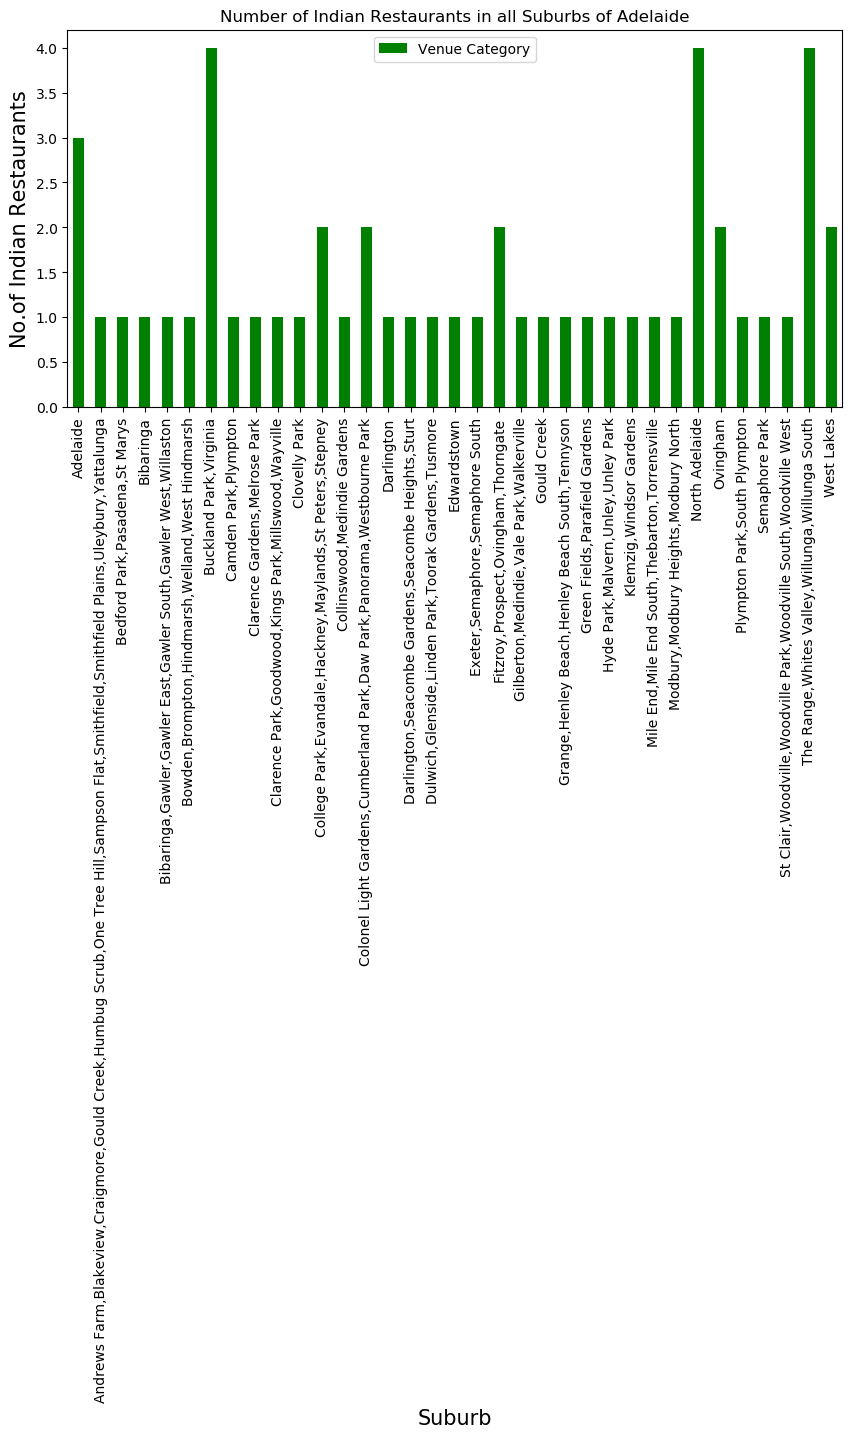

In [20]:
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Indian Restaurants in all Suburbs of Adelaide')
adelaideIndianRestaurants.groupby('Neighborhood')['Venue Category'].count().plot(kind='bar', color= 'g')
plt.xlabel('Suburb', fontsize = 15)                                     
plt.ylabel('No.of Indian Restaurants', fontsize=15)   
plt.legend()
plt.show()

We can see that below suburbs have the highest number of Indian Restaurants.
* Adelaide (City of Adelaide)
* North Adelaide (City of Adelaide)
* Buckland Park, Virginia (City of Playford)
* Fitzroy, Prospect, Ovingham, Thorngate (City of Prospect)
* The Range, Whites Valley, Willunga, Willunga South (City of Onkaparinga)

Now we plot the Number of Indian Restaurants per LGA.

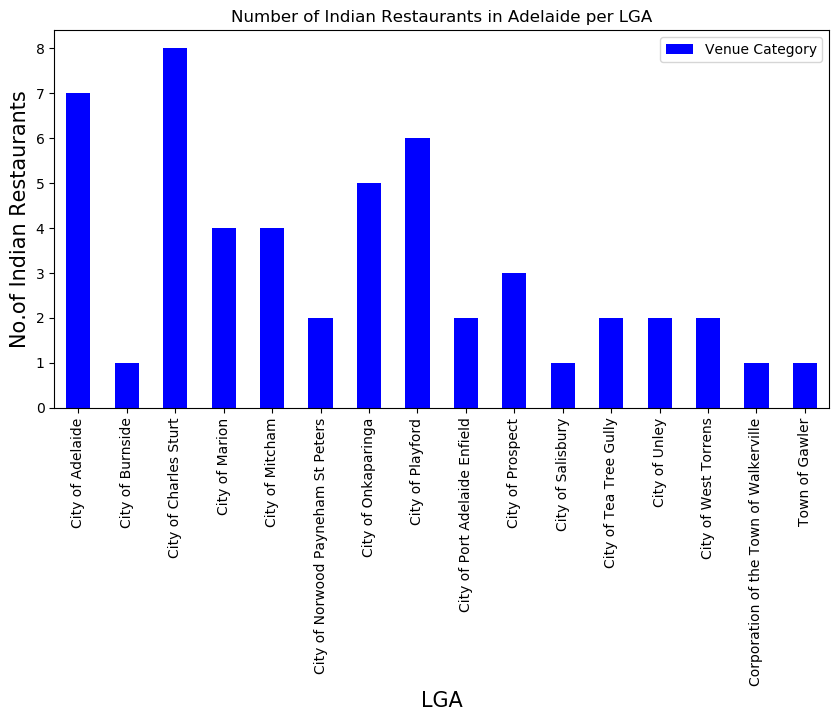

In [21]:
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Indian Restaurants in Adelaide per LGA')
adelaideIndianRestaurants.groupby('LGA')['Venue Category'].count().plot(kind='bar', color= 'b')
plt.xlabel('LGA', fontsize = 15)                                     
plt.ylabel('No.of Indian Restaurants', fontsize=15)   
plt.legend()
plt.show()

We can see that City of Charles Sturt and City of Adelaide are top two with respect to number of Indian Restaurants.

Now we determine the top 100 venues for the suburbs of Adelaide

In [23]:
adelaide_nearbyvenues = getNearbyVenues(lga=city_adelaide['LGA'],
                                   names=city_adelaide['Suburb'],
                                   latitudes=city_adelaide['Latitude'],
                                   longitudes=city_adelaide['Longitude']
                                )

In [24]:
adelaide_nearbyvenues.head()

,LGA,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category ID
0,City of Adelaide,Adelaide,-34.92565,138.599907,Proof,-34.925730,138.598453,Wine Bar,4bf58dd8d48988d123941735
1,City of Adelaide,Adelaide,-34.92565,138.599907,Pizza E Mozzarella Bar,-34.925683,138.600868,Pizza Place,4bf58dd8d48988d1ca941735
2,City of Adelaide,Adelaide,-34.92565,138.599907,Blefari Caffe & Cucina,-34.927201,138.600413,Café,4bf58dd8d48988d16d941735
3,City of Adelaide,Adelaide,-34.92565,138.599907,Pranzo,-34.925364,138.600672,Italian Restaurant,4bf58dd8d48988d110941735
4,City of Adelaide,Adelaide,-34.92565,138.599907,Sazon Kitchen,-34.924764,138.600554,Mexican Restaurant,4bf58dd8d48988d1c1941735


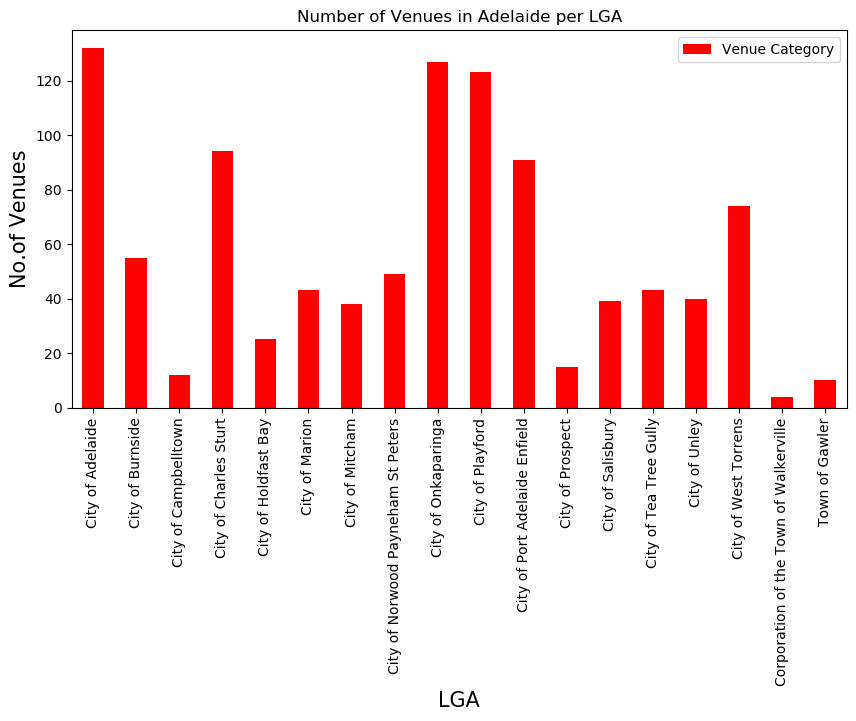

In [25]:
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Venues in Adelaide per LGA')
adelaide_nearbyvenues.groupby('LGA')['Venue Category'].count().plot(kind='bar', color= 'r')
plt.xlabel('LGA', fontsize = 15)                                     
plt.ylabel('No.of Venues', fontsize=15)   
plt.legend()
plt.show()

From the above plot we can see that City of Adelaide, City of Onkaparinga, City of Playford, City of Charles Sturt and City of Port Adelaide Enfield are top 5 LGAs with the most venues. So we will consider these 5 LGAs for our further analysis.

In [111]:
adelaide_final = adelaide_nearbyvenues[adelaide_nearbyvenues['LGA'].isin(['City of Adelaide', 'City of Onkaparinga', 'City of Playford', 'City of Charles Sturt',
                                                                          'City of Port Adelaide Enfield'])].reset_index(drop=True)
adelaide_final.shape

(567, 9)

In [112]:
# one hot encoding
adelaide_onehot = pd.get_dummies(adelaide_final[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood & LGA columns back to dataframe
adelaide_onehot['Neighborhood'] = adelaide_final['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [adelaide_onehot.columns[-1]] + list(adelaide_onehot.columns[:-1])
adelaide_onehot = adelaide_onehot[fixed_columns]
adelaide_onehot.head()

# Check returned one hot encoding data:
print('One hot encoding returned "{}" rows.'.format(adelaide_onehot.shape[0]))

# Regroup rows by neighborhood and mean of frequency occurrence per category.
adelaide_grouped = adelaide_onehot.groupby('Neighborhood').mean().reset_index()

print('One hot encoding re-group returned "{}" rows.'.format(adelaide_grouped.shape[0]))
adelaide_grouped.head()

One hot encoding returned "567" rows.
One hot encoding re-group returned "56" rows.


,Neighborhood,Afghan Restaurant,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Baseball Field,Big Box Store,Boat or Ferry,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cricket Ground,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food Court,Football Stadium,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lighthouse,Liquor Store,Malay Restaurant,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Music Store,Nightclub,Noodle House,Other Great Outdoors,Other Repair Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Recreation Center,Resort,Restaurant,River,Road,Sandwich Place,Scandinavian Restaurant,School,Sculpture Garden,Shopping Mall,Snack Place,Soccer Field,Spanish Restaurant,Speakeasy,Sports Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,"Aberfoyle Park,Chandlers Hill,Flagstaff Hill,H...",0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,1.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.00
1,Adelaide,0.0,0.0,0.01,0.0,0.01,0.03,0.01,0.01,0.01,0.08,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.0,0.08,0.01,0.0,0.02,0.0,0.01,0.08,0.01,0.0,0.01,0.0,0.02,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.02,0.05,0.0,0.02,0.01,0.0,0.03,0.03,0.01,0.0,0.0,0.01,0.0,0.01,0.02,0.0,0.01,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.04,0.02,0.0,0.0,0.01,0.0,0.0,0.010000,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.01,0.0,0.030000,0.03
2,"Albert Park,Cheltenham,Hendon,Royal Park",0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.333333,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.333333,0.00
3,"Alberton,Queenstown",0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.333333,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.333333,0.00
4,"Allenby Gardens,Beverley,Kilkenny",0.0,0.0,0.00,0.0,0.00,0.20,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0

Finding the top 5 most common venues for each neighborhood

In [113]:
num_top_venues = 5

for hood in adelaide_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = adelaide_grouped[adelaide_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [114]:
#this function will sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe to display the top 10 venues for each neighborhood.

In [138]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = adelaide_grouped['Neighborhood']

for ind in np.arange(adelaide_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(adelaide_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aberfoyle Park,Chandlers Hill,Flagstaff Hill,H...",Business Service,Wine Bar,French Restaurant,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Adelaide,Bar,Café,Coffee Shop,Hotel,Sculpture Garden,Asian Restaurant,Vietnamese Restaurant,Italian Restaurant,Japanese Restaurant,Wine Bar
2,"Albert Park,Cheltenham,Hendon,Royal Park",Vietnamese Restaurant,Supermarket,Fruit & Vegetable Store,Hobby Shop,History Museum,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market
3,"Alberton,Queenstown",Vietnamese Restaurant,Supermarket,Fruit & Vegetable Store,Hobby Shop,History Museum,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market
4,"Allenby Gardens,Beverley,Kilkenny",Pet Store,Asian Restaurant,Italian Restaurant,Gym,Café,Football Stadium,Department Store,Dessert Shop,Dog Run,Electronics Store


## 3. Cluster Neighborhoods

Now we use *k*-means to cluster the neighborhoods into 5 clusters

In [139]:
# set number of clusters
kclusters = 3
adelaide_grouped_clustering = adelaide_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(adelaide_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [140]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
adelaide_merged = city_adelaide

# merge adelaide_grouped with city_adelaide to add latitude/longitude for each neighborhood
adelaide_merged = adelaide_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Suburb')
adelaide_merged.dropna(inplace=True)
adelaide_merged.head()

,PostalCode,LGA,Suburb,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5000,City of Adelaide,Adelaide,-34.925650,138.599907,0.0,Bar,Café,Coffee Shop,Hotel,Sculpture Garden,Asian Restaurant,Vietnamese Restaurant,Italian Restaurant,Japanese Restaurant,Wine Bar
1,5006,City of Adelaide,North Adelaide,-34.909165,138.594803,0.0,Pub,Burger Joint,Italian Restaurant,Asian Restaurant,Thai Restaurant,Café,Wine Bar,Coffee Shop,Restaurant,Park
2,5007,City of Charles Sturt,"Bowden,Brompton,Hindmarsh,Welland,West Hindmarsh",-34.901890,138.570164,0.0,Gym,Afghan Restaurant,Pub,Liquor Store,Bar,Bakery,Indian Restaurant,Burger Joint,Dog Run,Electronics Store
3,5008,City of Charles Sturt,"Croydon,Devon Park,Renown Park,Ridleyton,West ...",-34.888220,138.567377,0.0,Electronics Store,Thai Restaurant,Fast Food Restaurant,Bakery,Wine Bar,French Restaurant,Department Store,Dessert Shop,Dog Run,Farmers Market
4,5008,City of Port Adelaide Enfield,"Croydon Park,Devon Park,Dudley Park",-34.888220,138.567377,0.0,Electronics Store,Thai Restaurant,Fast Food Restaurant,Bakery,Wine Bar,French Restaurant,Department Store,Dessert Shop,Dog Run,Farmers Market


Visualizing the resulting clusters

In [143]:
# create map
map_adelaide = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

adelaide_merged['Cluster'] =adelaide_merged['Cluster'].astype(int)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(adelaide_merged['Latitude'], adelaide_merged['Longitude'], adelaide_merged['Suburb'], adelaide_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_adelaide)

# mark the indian restaurants
for lat, lng, label in zip(adelaideIndianRestaurants['Neighborhood Latitude'], adelaideIndianRestaurants['Neighborhood Longitude'],
                           adelaideIndianRestaurants['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.Marker(location=[lat, lng], 
                            icon=folium.Icon(color='red',icon='coffee', prefix='fa'),
                            popup=label).add_to(map_adelaide)  


        
map_adelaide

## 4. Examine Clusters

We now examine each cluster to determine the discriminating venue categories that distinguish each cluster.

In [144]:
adelaide_merged.loc[adelaide_merged['Cluster'] == 0, adelaide_merged.columns[[1] + list(range(5, adelaide_merged.shape[1]))]]

,LGA,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,City of Adelaide,0,Bar,Café,Coffee Shop,Hotel,Sculpture Garden,Asian Restaurant,Vietnamese Restaurant,Italian Restaurant,Japanese Restaurant,Wine Bar
1,City of Adelaide,0,Pub,Burger Joint,Italian Restaurant,Asian Restaurant,Thai Restaurant,Café,Wine Bar,Coffee Shop,Restaurant,Park
2,City of Charles Sturt,0,Gym,Afghan Restaurant,Pub,Liquor Store,Bar,Bakery,Indian Restaurant,Burger Joint,Dog Run,Electronics Store
3,City of Charles Sturt,0,Electronics Store,Thai Restaurant,Fast Food Restaurant,Bakery,Wine Bar,French Restaurant,Department Store,Dessert Shop,Dog Run,Farmers Market
4,City of Port Adelaide Enfield,0,Electronics Store,Thai Restaurant,Fast Food Restaurant,Bakery,Wine Bar,French Restaurant,Department Store,Dessert Shop,Dog Run,Farmers Market
5,City of Charles Sturt,0,Pet Store,Asian Restaurant,Italian Restaurant,Gym,Café,Football Stadium,Department Store,Dessert Shop,Dog Run,Electronics Store
6,City of Port Adelaide Enfield,0,Snack Place,Pub,Australian Restaurant,Golf Course,Wine Bar,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market
7,City of Charles Sturt,0,Fast Food Restaurant,Vietnamese Restaurant,Pub,Supermarket,Football Stadium,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store
8,City of Charles Sturt,0,Vietnamese Restaurant,Pet Store,Grocery Store,French Restaurant,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant
9,City of Port Adelaide Enfield,0,Vietnamese Restaurant,Pet Store,Grocery Store,French Restaurant,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant


In [145]:
adelaide_merged.loc[adelaide_merged['Cluster'] == 1, adelaide_merged.columns[[1] + list(range(5, adelaide_merged.shape[1]))]]

,LGA,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
147,City of Onkaparinga,1,Restaurant,Wine Bar,Football Stadium,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant
151,City of Onkaparinga,1,Restaurant,Sports Club,Wine Bar,Football Stadium,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market
152,City of Onkaparinga,1,Sports Club,Wine Bar,French Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant


In [146]:
adelaide_merged.loc[adelaide_merged['Cluster'] == 2, adelaide_merged.columns[[1] + list(range(5, adelaide_merged.shape[1]))]]

,LGA,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
123,City of Playford,2,Train Station,Wine Bar,French Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant
154,City of Onkaparinga,2,Train Station,Wine Bar,French Restaurant,Cupcake Shop,Department Store,Dessert Shop,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant


## Results and Discussion <a name="results"></a>

We have now reached at the end of the analysis, where we got a sneak peak of the 5 popular LGAs of Adelaide. As the business problem started with the best location for opening an Indian restaurant in one of the busiest districts, the data exploration was mostly concentrated on the LGAs with popular locations. I have used data from web resources like Wikipedia, python libraries like BeautifulSoup, Arcgis Geocoder and Foursquare API, to set up a very realistic data-analysis scenario. I have found out that City of Adelaide and City of Port Adelaide Enfield are dominated by restaurants as the the most common venue whereas City of Playford is dominated by bars and sport related venues as most common venues.

According to this analysis, City of Onkaparinga LGA will provide least competition for an upcoming Indian restaurant as the most common venue in this area does not include any Asian or Indian Restaurant. Also, the frequency of restaurants as common venue are very low compared to the remaining LGAs. So, definitely this region could potentially be a target for starting quality Indian restaurants. 

**Limitations:**
   - The clustering is completely based on the most common venues obtained from Foursquare data.
    
   - This analysis takes into consideration of only the 5 major LGAs of Adelaide, taking into account of all the LGAs would give us an even more realistic picture.

## Conclusion <a name="conclusion"></a>

Finally to conclude this project, I have used some popular python libraries to scrap the web-data, used Foursquare API to explore the major LGAs of Adelaide and determined the results of clustering and segmentation of LGAs using Folium leaflet map. Based on the analysis with the help of these methods I have made recommendations for probable locations for an Indian Restaurant. This is because in these areas, we have the highest number of popular venues visited by the people. Hence, opening an Indian restaurant here would definitely be a good business idea.
I have also listed some of the drawbacks and limitations and a chance for improvements to represent even more realistic results.